**Model Evaluation on Test Set**  

In this stage, we evaluate the performance of our trained models using the **dedicated Kazakh and English test datasets** prepared earlier. These datasets are labeled, balanced, and unique, consisting of real-world examples that were not seen during training. Each model is evaluated on its respective language dataset to assess its ability to detect semantic similarity and potential plagiarism.

We benchmarked multiple models, including:
- **Kazakh XLM-RoBERTa (base and large)** trained on the Kazakh dataset
- **English XLM-RoBERTa (base)** trained on the English dataset

For each model, we compute standard classification metrics such as:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

These metrics provide insight into the model’s ability to correctly identify both plagiarized (positive) and non-plagiarized (negative) text pairs. The evaluation results are then compared and visualized to determine which model performs best under the given conditions, especially in the low-resource Kazakh setting.

In [1]:
from google.colab import drive
# Mount Google Drive
googledrive = "/content/drive"
drive.mount(googledrive)

Mounted at /content/drive


In [ ]:

import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from IPython.display import display

# ✅ Define Paths for All Trained Models
models = {
    "kazakh_xlm_roberta_large_v3": "/content/drive/MyDrive/updating-pan-xml-files/kz-xlm-roberta-large-120K-v3/checkpoint-4000",
    "kazakh_xlm_roberta_large_v2": "/content/drive/MyDrive/updating-pan-xml-files/kazakh-xlm-roberta-large-v2",
    "kazakh_xlm_roberta_base": "/content/drive/MyDrive/updating-pan-xml-files/kazakh-roberta-base-120K",
    "english_xlm_roberta_base": "/content/drive/MyDrive/updating-pan-xml-files/english-xlm-roberta-60K-paragraphs",
}

# ✅ Define Test Datasets
datasets = {
    "kazakh": "/content/drive/MyDrive/updating-pan-xml-files/kz-3950-sentences-for-testing1.csv",
    "english": "/content/drive/MyDrive/updating-pan-xml-files/en-4500-sentences-for-testing6.csv",
}

# ✅ Load Dataset
def load_dataset(dataset_path):
    return pd.read_csv(dataset_path)

# ✅ Function to classify text pairs using a model
def classify_plagiarism(model, tokenizer, text1, text2, device):
    inputs = tokenizer(
        f"{text1} {tokenizer.sep_token} {text2}",
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return prediction

# ✅ Evaluate one model on one dataset
def evaluate_model(model_path, dataset_path, device):
    df = load_dataset(dataset_path)

    # Load tokenizer and model from local directory
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
    model.to(device)
    model.eval()

    actual_labels = df["label"].tolist()
    predicted_labels = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
        pred = classify_plagiarism(
            model, tokenizer, row["source_text"], row["suspicious_text"], device
        )
        predicted_labels.append(pred)

    # Evaluation metrics
    actual = np.array(actual_labels)
    predicted = np.array(predicted_labels)

    accuracy = np.mean(predicted == actual)
    tp = np.sum((predicted == 1) & (actual == 1))
    fp = np.sum((predicted == 1) & (actual == 0))
    fn = np.sum((predicted == 0) & (actual == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Evaluate All Models
results = {}
for model_name, model_path in models.items():
    dataset_path = datasets["kazakh"] if "kazakh" in model_name else datasets["english"]
    print(f"\n🔍 Evaluating: {model_name}")
    results[model_name] = evaluate_model(model_path, dataset_path, device)

# ✅ Show and save results
df_results = pd.DataFrame.from_dict(results, orient="index")
display(df_results)

save_path = "/content/drive/MyDrive/updating-pan-xml-files/result/benchmark2.csv"
df_results.to_csv(save_path)
print(f"\n✅ Benchmarking complete! Results saved at: {save_path}")


🔍 Evaluating: kazakh_xlm_roberta_large_v3


Evaluating: 100%|██████████| 3955/3955 [02:03<00:00, 32.00it/s]



🔍 Evaluating: kazakh_xlm_roberta_large_v2


Evaluating: 100%|██████████| 3955/3955 [02:03<00:00, 32.02it/s]



🔍 Evaluating: kazakh_xlm_roberta_base


Evaluating: 100%|██████████| 3955/3955 [00:40<00:00, 98.39it/s]



🔍 Evaluating: english_xlm_roberta_base


Evaluating: 100%|██████████| 4535/4535 [00:45<00:00, 98.87it/s]


,accuracy,precision,recall,f1
kazakh_xlm_roberta_large_v3,0.951201,0.994457,0.907436,0.948955
kazakh_xlm_roberta_large_v2,0.951960,0.996665,0.906930,0.949682
kazakh_xlm_roberta_base,0.747661,0.668040,0.984320,0.795910
english_xlm_roberta_base,0.964278,0.943158,0.988090,0.965101



✅ Benchmarking complete! Results saved at: /content/drive/MyDrive/updating-pan-xml-files/result/benchmark2.csv


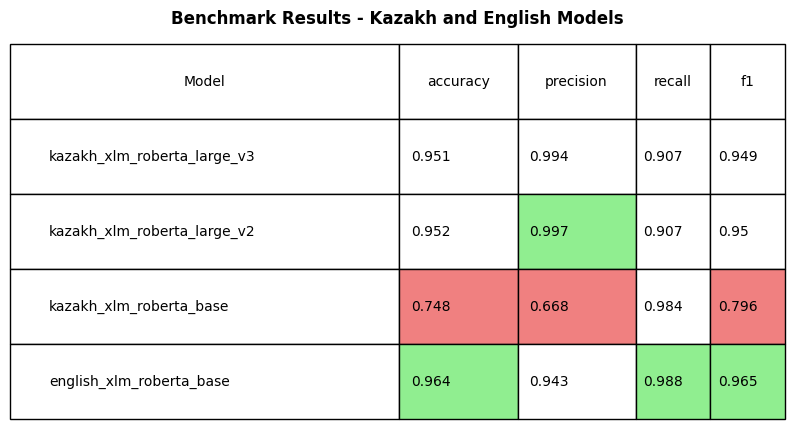

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the benchmark results
file_path = "/content/drive/MyDrive/updating-pan-xml-files/result/benchmark2.csv"
df_all = pd.read_csv(file_path, index_col=0)

# Round numbers to three decimal places
df_all = df_all.round(3)

def highlight_best_worst_combined(df):
    """
    Create a matplotlib table for 'df' with:
      - Green for the best (max) value in each column.
      - Red for the worst (min) value only if the difference with second worst >= 0.1.
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_title(
        "Benchmark Results - Kazakh and English Models",
        fontsize=12,
        fontweight="bold",
        pad=15
    )

    ax.axis("off")

    table_data = [[idx] + row.tolist() for idx, row in df.iterrows()]
    col_labels = ["Model"] + df.columns.tolist()

    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc="left",
        loc="center",
        bbox=[0, 0, 1, 1]
    )

    for col_idx in range(1, len(df.columns) + 1):
        column_values = df.iloc[:, col_idx - 1]
        max_val = column_values.max()
        sorted_values = column_values.sort_values()
        min_val = sorted_values.iloc[0]
        second_min_val = sorted_values.iloc[1]

        for row_idx in range(len(df)):
            cell = table[row_idx + 1, col_idx]
            cell_value = df.iloc[row_idx, col_idx - 1]
            if cell_value == max_val:
                cell.set_facecolor("lightgreen")
            elif cell_value == min_val and abs(min_val - second_min_val) >= 0.1:
                cell.set_facecolor("lightcoral")

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    for i in range(len(col_labels)):
        table.auto_set_column_width(col=i)

    plt.subplots_adjust(top=0.8, bottom=0.05)

    return fig

# Plot combined results
fig_combined = highlight_best_worst_combined(df_all)
plt.show()

**Conclusion**

The benchmarking analysis reveals distinct performance differences among the evaluated plagiarism detection models. The **English XLM-RoBERTa Base** model clearly outperformed the others, achieving the highest accuracy, recall, and F1 scores, underscoring its effectiveness for English text analysis. Among the Kazakh-language models, **Kazakh XLM-RoBERTa Large v2** achieved the highest precision, slightly surpassing the **Kazakh XLM-RoBERTa Large v3**, although both large models performed comparably well across most metrics. In contrast, the **Kazakh XLM-RoBERTa Base** demonstrated significantly lower performance, particularly in accuracy, precision, and F1-score, indicating that the larger-sized models (v2 and v3) are notably more effective for Kazakh plagiarism detection tasks.